In [1]:
#!/usr/bin/python
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

import scipy
from scipy.sparse import load_npz
import numpy as np
import pandas as pd


class GenoVAE(nn.Module):
	def __init__(self):

		super(GenoVAE, self).__init__()

		# self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
		# self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
		# self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
		self.linear_0 = nn.Linear(15988, 512)
		self.linear_012 = nn.Linear(512, 256)
		self.linear_1 = nn.Linear(256, 32)
		self.linear_2 = nn.Linear(256, 32)

		self.linear_3 = nn.Linear(32, 256)
		self.linear_34 = nn.Linear(256, 512)
		# self.gru = nn.GRU(292, 501, 3, batch_first=True)
		self.linear_4 = nn.Linear(512, 15988)
		
		self.relu = nn.ReLU()
		self.softmax = nn.Softmax()

	def encode(self, x):
		# x = self.relu(self.conv_1(x))
		# x = self.relu(self.conv_2(x))
		# x = self.relu(self.conv_3(x))
		# x = x.view(x.size(0), -1)
		x = self.relu(self.linear_0(x))
		x = F.selu(self.linear_012(x))
		return self.linear_1(x), self.linear_2(x)

	def sampling(self, z_mean, z_logvar):
		epsilon = 1e-2 * torch.randn_like(z_logvar)
		return torch.exp(0.5 * z_logvar) * epsilon + z_mean

	def decode(self, z):
		z = F.selu(self.linear_3(z))
		out_reshape = F.selu(self.linear_34(z))
		# z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
		# output, hn = self.gru(z)
		# out_reshape = output.contiguous().view(-1, output.size(-1))
		y0 = F.softmax(self.linear_4(out_reshape), dim = 1)
		y = y0.contiguous()
		return y

	def forward(self, x):
		z_mean, z_logvar = self.encode(x)
		self.z = self.sampling(z_mean, z_logvar)
		return self.decode(self.z), z_mean, z_logvar, self.z


def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
	xent_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
	kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
	return xent_loss + kl_loss
	

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GenoVAE().to(device)

/home/hengshi/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
a = list(model.parameters())

In [2]:
path_save = 'output' 
# data
path_data = '/nfs/turbo/umms-welchjd/hengshi/GAN/data/Genotype/sparse_gene_anno_matrix.npz'
data_npz = load_npz(path_data).toarray()

random_state = np.random.RandomState(seed = 123)
permutation = random_state.permutation(len(data_npz))
n_train = int(len(data_npz) * 0.8)
n_test = len(data_npz) - n_train
batch_size = 256

data_train, data_test = data_npz[permutation[:n_train]], data_npz[permutation[n_train:]]

data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))
data_test = torch.utils.data.TensorDataset(torch.from_numpy(data_test))
train_loader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, shuffle = True)

# model 
torch.manual_seed(42)

epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GenoVAE().to(device)
optimizer = optim.Adam(model.parameters())


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device, dtype = torch.float)

        check = np.random.sample(1)[0]
        data_len = data.shape[0]

        if check > 0.5 and data_len % 2 == 0:
            half_len = int(data_len / 2)
            data_first, data_second = data[:half_len], data[half_len]
            data = torch.logical_or(data_first, data_second).to(device, dtype = torch.float)

        optimizer.zero_grad()
        output, mean, logvar, _ = model(data)

        if batch_idx == 0:
            inp = data.cpu().numpy()
            outp = output.cpu().detach().numpy()
            lab = data.cpu().numpy()
            #print("Input:")
            #print(decode_smiles_from_indexes(map(from_one_hot_array, inp[0]), charset))
            #print("Label:")
            #print(decode_smiles_from_indexes(map(from_one_hot_array, lab[0]), charset))
            # sampled = outp[0].reshape(1, 120, len(charset)).argmax(axis=2)[0]
            # print("Output:")
            # print(decode_smiles_from_indexes(sampled, charset))
            model.eval()
            test_loss = 0
            with torch.no_grad():
                for batch_test_idx, testdata in enumerate(test_loader):
                    testdata = testdata[0].to(device, dtype = torch.float)

                    check = np.random.sample(1)[0]
                    data_len = testdata.shape[0]

                    if check > 0.5 and data_len % 2 == 0:
                        half_len = int(data_len / 2)
                        data_first, data_second = testdata[:half_len], testdata[half_len]
                        testdata = torch.logical_or(data_first, data_second).to(device, dtype = torch.float)

                    output_test, mean_test, logvar_test, _ = model(testdata)
                    tloss = vae_loss(output_test, testdata, mean_test, logvar_test)
                    test_loss += tloss.item() * testdata.shape[0]
                test_loss /= len(test_loader.dataset)
            model.train()

        loss = vae_loss(output, data, mean, logvar)
        loss.backward()
        train_loss += loss.item() * data.shape[0]
        optimizer.step()
    train_loss /= len(train_loader.dataset)
#         if batch_idx % 100 == 0:
#             print(f'{epoch} / {batch_idx}\t{loss:.4f}')
    print('train', train_loss / len(train_loader.dataset))
    return train_loss, test_loss



/home/hengshi/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device, dtype = torch.float)

        check = np.random.sample(1)[0]
        data_len = data.shape[0]

        if check > 0.5 and data_len % 2 == 0:
            half_len = int(data_len / 2)
            data_first, data_second = data[:half_len], data[half_len]
            data = torch.logical_or(data_first, data_second).to(device, dtype = torch.float)

        optimizer.zero_grad()
        output, mean, logvar, _ = model(data)

        if batch_idx == 0:
            inp = data.cpu().numpy()
            outp = output.cpu().detach().numpy()
            lab = data.cpu().numpy()
            #print("Input:")
            #print(decode_smiles_from_indexes(map(from_one_hot_array, inp[0]), charset))
            #print("Label:")
            #print(decode_smiles_from_indexes(map(from_one_hot_array, lab[0]), charset))
            # sampled = outp[0].reshape(1, 120, len(charset)).argmax(axis=2)[0]
            # print("Output:")
            # print(decode_smiles_from_indexes(sampled, charset))
            model.eval()
            test_loss = 0
            with torch.no_grad():
                for batch_test_idx, testdata in enumerate(test_loader):
                    testdata = testdata[0].to(device, dtype = torch.float)

                    check = np.random.sample(1)[0]
                    data_len = testdata.shape[0]

                    if check > 0.5 and data_len % 2 == 0:
                        half_len = int(data_len / 2)
                        data_first, data_second = testdata[:half_len], testdata[half_len]
                        testdata = torch.logical_or(data_first, data_second).to(device, dtype = torch.float)

                    output_test, mean_test, logvar_test, _ = model(testdata)
                    tloss = vae_loss(output_test, testdata, mean_test, logvar_test)
                    test_loss += tloss.item() * testdata.shape[0]
                    print("Step: " + str(batch_idx) + ", test iteration: " + str(batch_test_idx))
                test_loss /= len(test_loader.dataset)
                print('test: ', test_loss)
            model.train()

        loss = vae_loss(output, data, mean, logvar)
        loss.backward()
        train_loss += loss.item() * data.shape[0]
        optimizer.step()
        print("training iteration: " + str(batch_idx))
    train_loss /= len(train_loader.dataset)
    print('train: ', train_loss )

/home/hengshi/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Step: 0, test iteration: 0
Step: 0, test iteration: 1
Step: 0, test iteration: 2
Step: 0, test iteration: 3
Step: 0, test iteration: 4
Step: 0, test iteration: 5
Step: 0, test iteration: 6
Step: 0, test iteration: 7
Step: 0, test iteration: 8
Step: 0, test iteration: 9
Step: 0, test iteration: 10
Step: 0, test iteration: 11
Step: 0, test iteration: 12
Step: 0, test iteration: 13
Step: 0, test iteration: 14
test:  17807.31240459915
training iteration: 0
training iteration: 1
training iteration: 2
training iteration: 3
training iteration: 4
training iteration: 5
training iteration: 6
training iteration: 7
training iteration: 8
training iteration: 9
training iteration: 10
training iteration: 11
training iteration: 12
training iteration: 13
training iteration: 14
training iteration: 15
training iteration: 16
training iteration: 17
training iteration: 18
training iteration: 19
training iteration: 20
training iteration: 21
training iteration: 22
training iteration: 23
training iteration: 24


KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
import os 



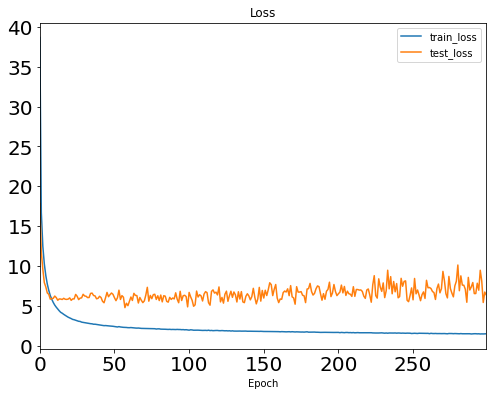

In [4]:
path_save = 'output_latent10_epoch300_GenotypeVAE_1em4_sumLoss_ZLZFineTune_lambda0p5_50removed'
train_loss = pd.read_csv(os.path.join(path_save, 'train_loss.csv'))
test_loss = pd.read_csv(os.path.join(path_save, 'test_loss.csv'))
train_loss.head()

train_loss.columns = ['Epoch', 'train_loss']
test_loss.columns = ['Epoch', 'test_loss']
newfig = (train_loss.merge(test_loss, on = "Epoch").set_index('Epoch')).plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Loss")
newfig.savefig(os.path.join(path_save, "losses.png"))


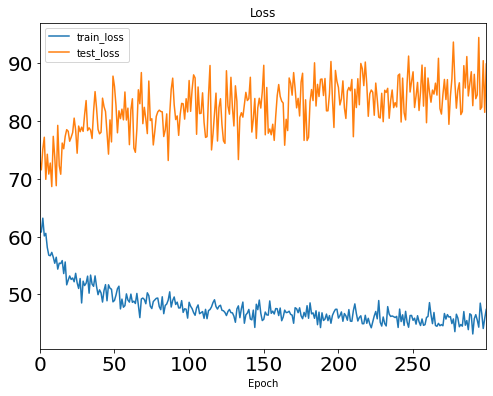

In [5]:

train_loss = pd.read_csv(os.path.join(path_save, 'train_vae_loss.csv'))
test_loss = pd.read_csv(os.path.join(path_save, 'test_vae_loss.csv'))
train_loss.head()

train_loss.columns = ['Epoch', 'train_loss']
test_loss.columns = ['Epoch', 'test_loss']
newfig = (train_loss.merge(test_loss, on = "Epoch").set_index('Epoch')).plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Loss")
newfig.savefig(os.path.join(path_save, "vae_losses.png"))


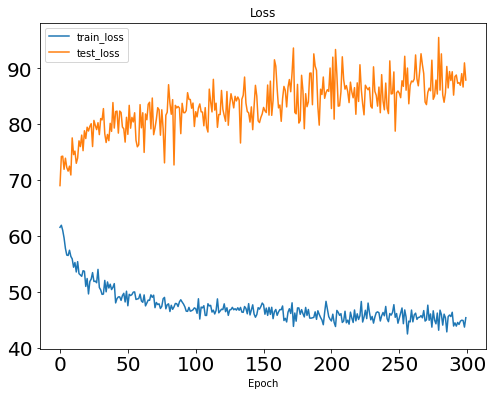

In [5]:
path_save = 'output_latent10_epoch300_GenotypeVAE_1em4_sumLoss_ZLZFineTune'
train_loss = pd.read_csv(os.path.join(path_save, 'train_vae_loss.csv'))
test_loss = pd.read_csv(os.path.join(path_save, 'test_vae_loss.csv'))
train_loss.head()

train_loss.columns = ['Epoch', 'train_loss']
test_loss.columns = ['Epoch', 'test_loss']
newfig = (train_loss.merge(test_loss, on = "Epoch").set_index('Epoch')).plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Loss")
newfig.savefig(os.path.join(path_save, "losses_vae.png"))


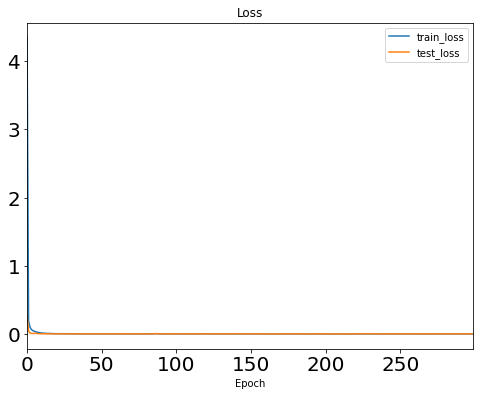

In [9]:
train_loss.columns = ['Epoch', 'train_loss']
test_loss.columns = ['Epoch', 'test_loss']
newfig = train_loss.merge(test_loss, on = "Epoch").set_index('Epoch').plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Loss")
newfig.savefig(os.path.join(path_save, "losses.png"))

Text(0.5, 1.0, 'Loss')

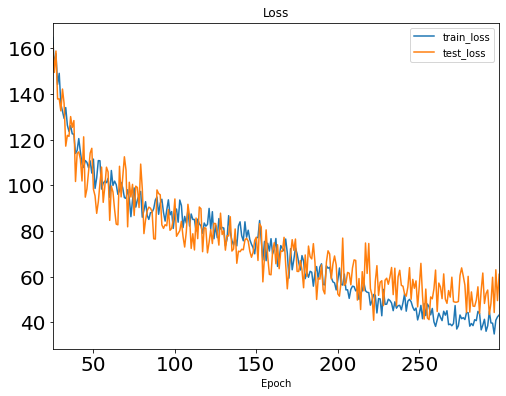

In [16]:
train_loss.columns = ['Epoch', 'train_loss']
test_loss.columns = ['Epoch', 'test_loss']
newfig = (train_loss.merge(test_loss, on = "Epoch").set_index('Epoch')/1).iloc[25:, :].plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Loss")
#newfig.savefig(os.path.join(path_save, "losses.png"))

In [6]:
train_loss.merge(test_loss, on = "Epoch").set_index('Epoch')/256

,train_loss,test_loss
Epoch,,
0,36.516063,28.635010
1,23.044486,21.296916
2,14.652937,13.863775
3,9.632119,9.198874
4,6.747380,6.505941
...,...,...
295,0.154851,0.233417
296,0.136421,0.173143
297,0.159913,0.246216


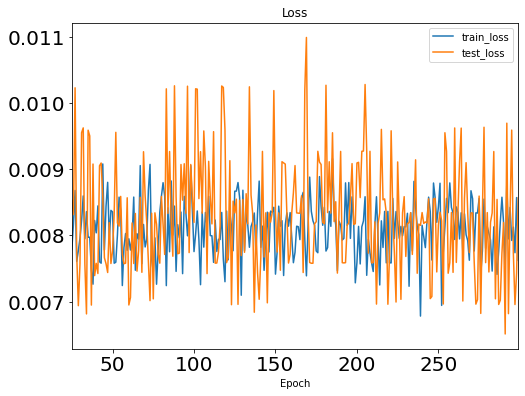

In [3]:
train_loss.columns = ['Epoch', 'train_loss']
test_loss.columns = ['Epoch', 'test_loss']
newfig = train_loss.merge(test_loss, on = "Epoch").set_index('Epoch').iloc[25:, :].plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Loss")
newfig.savefig(os.path.join(path_save, "losses25.png"))

Text(0.5, 1.0, 'Loss')

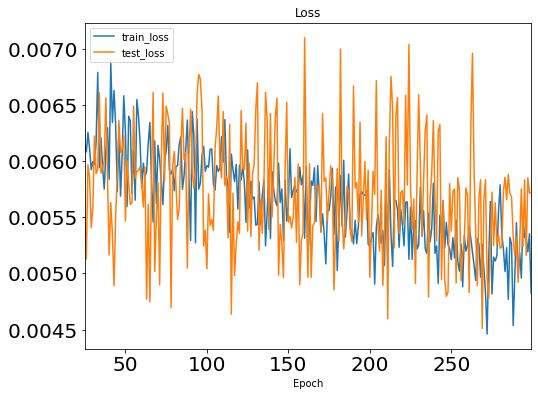

In [4]:
newfig = train_loss.merge(test_loss, on = "Epoch").set_index('Epoch').iloc[25:, :].plot(figsize = [8,6 ], fontsize = 20).get_figure()
plt.title("Loss")

# Visualization

In [3]:
#!/usr/bin/python
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

import scipy
from scipy.sparse import load_npz
import numpy as np
import pandas as pd


class GenoVAE(nn.Module):
	def __init__(self):

		super(GenoVAE, self).__init__()

		# self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
		# self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
		# self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
		self.linear_0 = nn.Linear(15988, 512)
		self.linear_012 = nn.Linear(512, 256)
		self.linear_1 = nn.Linear(256, 32)
		self.linear_2 = nn.Linear(256, 32)

		self.linear_3 = nn.Linear(32, 256)
		self.linear_34 = nn.Linear(256, 512)
		# self.gru = nn.GRU(292, 501, 3, batch_first=True)
		self.linear_4 = nn.Linear(512, 15988)
		
		self.relu = nn.ReLU()
		self.softmax = nn.Softmax()

	def encode(self, x):
		# x = self.relu(self.conv_1(x))
		# x = self.relu(self.conv_2(x))
		# x = self.relu(self.conv_3(x))
		# x = x.view(x.size(0), -1)
		x = self.relu(self.linear_0(x))
		x = F.selu(self.linear_012(x))
		return self.linear_1(x), self.linear_2(x)

	def sampling(self, z_mean, z_logvar):
		epsilon = 1e-2 * torch.randn_like(z_logvar)
		return torch.exp(0.5 * z_logvar) * epsilon + z_mean

	def decode(self, z):
		z = F.selu(self.linear_3(z))
		out_reshape = F.selu(self.linear_34(z))
		# z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
		# output, hn = self.gru(z)
		# out_reshape = output.contiguous().view(-1, output.size(-1))
		y0 = F.softmax(self.linear_4(out_reshape), dim = 1)
		y = y0.contiguous()
		return y

	def forward(self, x):
		z_mean, z_logvar = self.encode(x)
		self.z = self.sampling(z_mean, z_logvar)
		return self.decode(self.z), z_mean, z_logvar, self.z


def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
	xent_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
	kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
	return xent_loss + kl_loss

In [2]:
model

NameError: name 'model' is not defined

In [10]:
path_save = 'output' 
# data
path_data = '/nfs/turbo/umms-welchjd/hengshi/GAN/data/Genotype/sparse_gene_anno_matrix.npz'
data_npz = load_npz(path_data).toarray()

random_state = np.random.RandomState(seed = 123)
permutation = random_state.permutation(len(data_npz))
n_train = int(len(data_npz) * 0.8)
n_test = len(data_npz) - n_train
batch_size = 256

data_train, data_test = data_npz[permutation[:n_train]], data_npz[permutation[n_train:]]


In [12]:
data_npz.shape

(18832, 15988)

In [13]:
ls /nfs/turbo/umms-welchjd/hengshi/GAN/data/Genotype/

anno.npy*  goa_human.gaf*     goa_human.xlsx*    sparse_gene_anno_matrix.npz*
gene.npy*  goa_human.gaf.gz*  preprocess.ipynb*


In [14]:
dataVAR = pd.read_csv('/scratch/welchjd_root/welchjd/hengshi/GAN/perturb_gan/data/GI/GI_processed_KeptPerturb_RAW_LibraryCheck_adataVAR.csv')

In [16]:
path_cond = '/scratch/welchjd_root/welchjd/hengshi/GAN/perturb_gan/data/GI/cell_meta_Annotated_KeptPerturb_RAW_LibraryCheck_PyThon37.csv'
cond_data = pd.read_csv(path_cond)
cond_data.head()

,Unnamed: 0,perturbation,Group,Cluster,Perturb
0,0,ctrl/ctrl,NaN,NaN,NaN
1,1,TSC22D1/ctrl,NaN,NaN,NaN
2,2,KLF1/MAP2K6,PRO-GROWTH,Cluster2,KLF1/MAP2K6
3,3,ctrl10/ctrl,NaN,NaN,NaN
4,4,CEBPE/RUNX1T1,GRANULOCYTE/APOPTOSIS,Cluster7,CEBPE/RUNX1T1


Visualize embedding

In [4]:
path_geneanno = "/nfs/turbo/umms-welchjd/hengshi/GAN/data/Genotype/"
path_data = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/GI/'
path_model = "/scratch/welchjd_root/welchjd/hengshi/GAN/perturb_gan/genotype_vae/output/model_params.pt"
# else:
#   raise ValueError(
#       "{} already exists, Please provide an unexisting director for saving.".format(path_save))


# perturbation information data
cond_all = pd.read_csv(os.path.join(path_data, 'cell_meta_Annotated_KeptPerturb_RAW_LibraryCheck_PyThon37.csv'))
null_per_category = ['ctrl/ctrl', 'ctrl1/ctrl', 'ctrl10/ctrl', 'ctrl11/ctrl']
single_null_per_category = ['ctrl', 'ctrl1', 'ctrl10', 'ctrl11']

perturb_list = list(cond_all['perturbation'])
perturb1_list = []
perturb2_list = []
for i in range(len(perturb_list)):
    per1, per2 = perturb_list[i].split("/")
    perturb1_list.append(per1)
    perturb2_list.append(per2)

perturb1_list_collect = ['ctrl' if i in single_null_per_category else i for i in perturb1_list]
perturb2_list_collect = ['ctrl' if i in single_null_per_category else i for i in perturb2_list]

perturb_list_collect = [perturb1_list_collect[i] + "/" + perturb2_list_collect[i] for i in range(len(perturb2_list_collect))]
perturb_data_pd = pd.Series(perturb_list_collect).str.get_dummies("/")
perturb_data = perturb_data_pd.values.astype('float64')



perturb_data_pd_rowunique = perturb_data_pd.drop_duplicates()
perturb_col_names = np.array(list(perturb_data_pd_rowunique.columns))

# perturbation embedding data
data_npz = load_npz(os.path.join(path_geneanno, 'sparse_gene_anno_matrix.npz')).toarray()
gene_data = np.load(os.path.join(path_geneanno, 'gene.npy'))
anno_data = np.load(os.path.join(path_geneanno, 'anno.npy'))



# genotypeVAE model load
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GenoVAE().to(device)
model.load_state_dict(torch.load(path_model, map_location = device))
model.eval()

# treatment embedding
list_per_gene = []
anno_per_gene = None
for i in range(perturb_data_pd_rowunique.shape[0]):
    perturb_type = perturb_col_names[perturb_data_pd_rowunique.iloc[i, :].apply(lambda x: x > 0)]

    if len(perturb_type) == 1:
        per1, per2 = perturb_type[0], perturb_type[0]
    else:
        per1, per2 = perturb_type[0], perturb_type[1]


    anno1 = None
    if per1 in gene_data:
        indice1 = np.where(gene_data == per1)[0][0]
        anno1 = data_npz[[indice1]]

    anno2 = None
    if per2 in gene_data:
        indice2 = np.where(gene_data == per2)[0][0]
        anno2 = data_npz[[indice2]]

    if anno1 is not None and anno2 is not None:
        anno_perturb =  np.logical_or(anno1, anno2).astype(np.float64)
    elif anno1 is None and anno2 is not None:
        anno_perturb = anno2.astype(np.float64)
    elif anno1 is not None and anno2 is None:
        anno_perturb = anno1.astype(np.float64)
    else:
        anno_perturb = None

    if anno_perturb is not None:
        if anno_per_gene is None:
            anno_per_gene = anno_perturb
        else:
            anno_per_gene = np.concatenate([anno_per_gene, anno_perturb], axis = 0)
        list_per_gene.append(per1 + '/' + per2)

trt_whole_list = list_per_gene
list_emb_trt = list_per_gene
list_meta_trt = perturb_list_collect

/home/hengshi/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
anno_per_gene.shape

(230, 15988)

In [9]:
_, _, _, embdata_torch = model(torch.tensor(anno_per_gene).float().to(device))
embdata_numpy = embdata_torch.cpu().detach().numpy()

In [11]:
embdata_numpy.shape

(230, 32)

/home/hengshi/.local/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


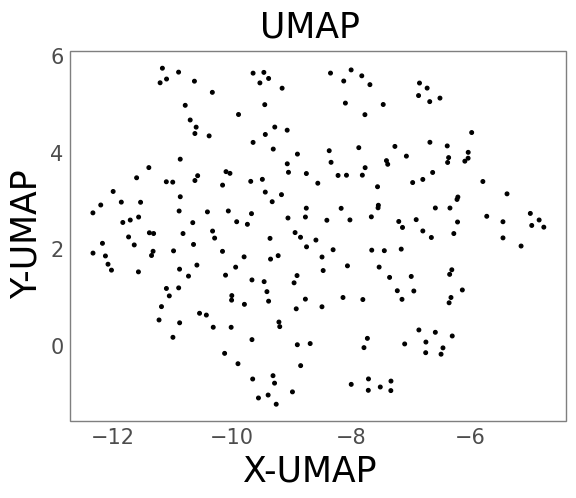

<ggplot: (-9223369057941657172)>

In [13]:
import umap
from plotnine import * 

trans_zinc = umap.UMAP(random_state = 42, min_dist = 0.5, n_neighbors=30).fit_transform(embdata_numpy)

df_tsne_pr_z = trans_zinc.copy()
df_tsne_pr_z = pd.DataFrame(df_tsne_pr_z)
df_tsne_pr_z['x-umap'] = trans_zinc[:,0]
df_tsne_pr_z['y-umap'] = trans_zinc[:,1]



chart_pr = ggplot(df_tsne_pr_z, aes(x= 'x-umap', y= 'y-umap') ) \
	+ geom_point(size=1, alpha = 1) + labs(x = "X-UMAP", y = "Y-UMAP") + theme_bw()  + theme(panel_background=element_rect(fill='white'),     
		title = element_text(size = 25), 
		axis_title_x=element_text(size = 25), axis_title_y=element_text(size = 25),
		axis_text_x=element_text(size = 15), axis_text_y=element_text(size = 15),
		legend_title=element_text(size = 20), legend_text=element_text(size = 20), 
		axis_ticks_major_y=element_blank(),
		axis_ticks_major_x=element_blank(),
		panel_grid = element_blank()) + ggtitle("UMAP")
chart_pr

In [15]:
ls

genotypeVAE.py  output/                     slurm-20263083.out
main.sh         output_latent256_epoch100/  test.ipynb


In [16]:
!pygmentize genotypeVAE.py

#!/usr/bin/python
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

import scipy
from scipy.sparse import load_npz
import numpy as np
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

class GenoVAE(nn.Module):
	def __init__(self):

		super(GenoVAE, self).__init__()

		# self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
		# self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
		# self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
		self.linear_0 = nn.Linear(15988, 512)
		self.linear_012 = nn.Linear(512, 256)
		self.linear_1 = nn.Linear(256, 32)
		self.linear_2 = nn.Linear(256, 32)

		self.linear_3 = nn.Linear(32, 256)
		self.linear_34 = nn.Linear(256, 512)
		# self.gru = nn.GRU(292, 501, 3, batch_first=True)
		self.linear_4 = nn.Linear(512, 15988)
		
		self.relu = nn.ReLU()
		self.softmax = nn.Softmax()

	def encode(self, x):
		# x = self.relu(self.conv_1(x))
		# x = self.relu(self.conv_2(x))
		# x = self.relu(

In [17]:
figure_path_pr = 'output/UMAP_moleVAE_300Epoch.png'
chart_pr.save(figure_path_pr, width=12, height=8, dpi=144)

/home/hengshi/.local/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 12 x 8 in image.
  from_inches(height, units), units))
/home/hengshi/.local/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: output/UMAP_moleVAE_300Epoch.png
  warn('Filename: {}'.format(filename))
/home/hengshi/.local/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/hengshi/.local/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/hengshi/.local/lib/python3.6/site-packages/plotnine/ggplot.py:722: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated 

# Test

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

import scipy
from scipy.sparse import load_npz
import numpy as np
import pandas as pd

In [2]:
linear_1 = nn.Linear(15988, 512)
linear_2 = nn.Linear(512, 256)
linear_3_mu = nn.Linear(256, 10)
linear_3_std = nn.Linear(256, 10)

bn1 = nn.BatchNorm1d(512)
bn2 = nn.BatchNorm1d(256)

# decoder
linear_4 = nn.Linear(10, 256)
linear_5 = nn.Linear(256, 512)
linear_6 = nn.Linear(512, 15988)

bn4 = nn.BatchNorm1d(256)
bn5 = nn.BatchNorm1d(512)

# activations		
relu = nn.ReLU()
softmax = nn.Softmax()
leaky = nn.LeakyReLU(negative_slope = 0.2)

dropout1 = nn.Dropout(p = 0.2)
dropout2 = nn.Dropout(p = 0.2)
dropout3 = nn.Dropout(p = 0.2)
dropout4 = nn.Dropout(p = 0.2)


In [7]:
z = torch.rand(10, 10)

In [8]:
z = linear_4(z)
z = bn4(z)
z = leaky(z)
z = dropout3(z)

z = linear_5(z)
z = bn5(z)
z = leaky(z)
z = dropout4(z)
# z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
# output, hn = self.gru(z)
# out_reshape = output.contiguous().view(-1, output.size(-1))


In [10]:
z.shape

torch.Size([10, 512])

In [11]:
m = linear_6(z)

In [12]:
m.shape

torch.Size([10, 15988])

In [13]:
y0 = F.softmax(m, dim = 1)
y = y0.contiguous()

In [14]:
y0.shape

torch.Size([10, 15988])

In [15]:
m

tensor([[ 0.2722, -0.1030,  0.1634,  ...,  0.4111, -0.0590,  0.6951],
        [ 0.8588, -0.0797, -0.3172,  ...,  0.1290, -0.5026, -0.0826],
        [ 0.8281, -0.3138, -0.0156,  ..., -0.3638,  0.2719, -0.1673],
        ...,
        [ 0.1607, -0.2021,  0.8523,  ...,  0.6332, -0.1159,  0.3610],
        [-0.2438,  0.8928, -0.4202,  ...,  0.0213, -0.7175, -0.6887],
        [ 1.0304,  0.1051,  0.8875,  ...,  0.2496,  0.6119,  0.3734]],
       grad_fn=<AddmmBackward>)

In [18]:
y0.sum(1).shape

torch.Size([10])

# Test Reconstruction

In [2]:
#!/usr/bin/python
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

import scipy
from scipy.sparse import load_npz
import numpy as np
import pandas as pd


class GenoVAE(nn.Module):
	def __init__(self):

		super(GenoVAE, self).__init__()

		# self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
		# self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
		# self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
		# encoder
		self.linear_1 = nn.Linear(15988, 512)
		self.linear_2 = nn.Linear(512, 256)
		self.linear_3_mu = nn.Linear(256, 10)
		self.linear_3_std = nn.Linear(256, 10)
		
		self.bn1 = nn.BatchNorm1d(512)
		self.bn2 = nn.BatchNorm1d(256)

		# decoder
		self.linear_4 = nn.Linear(10, 256)
		self.linear_5 = nn.Linear(256, 512)
		self.linear_6 = nn.Linear(512, 15988)

		self.bn4 = nn.BatchNorm1d(256)
		self.bn5 = nn.BatchNorm1d(512)
		
		# activations		
		self.relu = nn.ReLU()
		self.softmax = nn.Softmax()
		self.leaky = nn.LeakyReLU(negative_slope = 0.2)
		self.sigmoid = nn.Sigmoid()

		self.dropout1 = nn.Dropout(p = 0.2)
		self.dropout2 = nn.Dropout(p = 0.2)
		self.dropout3 = nn.Dropout(p = 0.2)
		self.dropout4 = nn.Dropout(p = 0.2)

		
	def encode(self, x):
		# layer 1
		x = self.linear_1(x)
		x = self.bn1(x)
		x = self.leaky(x)
		x = self.dropout1(x)

		# layer 2
		x = self.linear_2(x)
		x = self.bn2(x)
		x = self.leaky(x)
		x = self.dropout2(x)

		# mean and std layers
		return self.linear_3_mu(x), self.linear_3_std(x)

	def sampling(self, z_mean, z_logvar):
		epsilon = 1e-2 * torch.randn_like(z_logvar)
		return torch.exp(0.5 * z_logvar) * epsilon + z_mean

	def decode(self, z):
		z = self.linear_4(z)
		z = self.bn4(z)
		z = self.leaky(z)
		z = self.dropout3(z)
		
		z = self.linear_5(z)
		z = self.bn5(z)
		z = self.leaky(z)
		z = self.dropout4(z)
		# z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
		# output, hn = self.gru(z)
		# out_reshape = output.contiguous().view(-1, output.size(-1))
		y0 = self.sigmoid(self.linear_6(z))
		y = y0.contiguous()
		return y

	def forward(self, x):
		z_mean, z_logvar = self.encode(x)
		self.z = self.sampling(z_mean, z_logvar)
		return self.decode(self.z), z_mean, z_logvar, self.z



def vae_loss(x_decoded_mean, x, z_mean, z_logvar):

	xent_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average = True)
	kl_loss = -0.5 * torch.mean(torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp(), 1))
	return xent_loss + kl_loss


In [7]:
path_save = 'output' 
# data
path_data = '/nfs/turbo/umms-welchjd/hengshi/GAN/data/Genotype/sparse_gene_anno_matrix.npz'
data_npz = load_npz(path_data).toarray()

random_state = np.random.RandomState(seed = 123)
permutation = random_state.permutation(len(data_npz))
n_train = int(len(data_npz) * 0.8)
n_test = len(data_npz) - n_train
batch_size = 256

data_train, data_test = data_npz[permutation[:n_train]], data_npz[permutation[n_train:]]

data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))
data_test = torch.utils.data.TensorDataset(torch.from_numpy(data_test))
train_loader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, shuffle = True)

# model 
torch.manual_seed(42)

epochs = 300
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GenoVAE().to(device)
model.load_state_dict(torch.load("output/model_params.pt", map_location = device))
model.eval()

/home/hengshi/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


GenoVAE(
  (linear_1): Linear(in_features=15988, out_features=512, bias=True)
  (linear_2): Linear(in_features=512, out_features=256, bias=True)
  (linear_3_mu): Linear(in_features=256, out_features=10, bias=True)
  (linear_3_std): Linear(in_features=256, out_features=10, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_4): Linear(in_features=10, out_features=256, bias=True)
  (linear_5): Linear(in_features=256, out_features=512, bias=True)
  (linear_6): Linear(in_features=512, out_features=15988, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
  (leaky): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
  (dropout1): Dropout(p=0.2, inplace=False

In [11]:
data_train, data_test = data_npz[permutation[:n_train]], data_npz[permutation[n_train:]]

In [35]:
rec, _, _, _ = model(torch.tensor(data_train[[0]]).type(torch.float))

In [36]:
rec

tensor([[9.7278e-04, 5.8370e-05, 6.0626e-06,  ..., 1.3260e-05, 4.9104e-06,
         2.8806e-04]], grad_fn=<SigmoidBackward>)

In [38]:
data_train[0].sum()

6

In [62]:
np.where(data_train[0] == 1)[0]

array([2068, 2183, 2688, 4588, 7442, 7718])

In [40]:
(rec > 0.5).sum()

tensor(1)

In [66]:
torch.where(rec[0] > 0.5)[0]

tensor([2068])

In [14]:
a = torch.where(rec[0] > 0.5)[0].numpy()
a

array([  318,   319,   320,   345,  1652,  1653,  2068,  2119,  2129,
        2168,  2227,  2569,  2920,  3336,  3597,  4558,  4560,  4561,
        4740,  4925,  6154,  6255,  6257,  6258,  6289,  6352,  7072,
        8035,  8380,  8525,  9300,  9575, 10566, 12071, 12073, 13811,
       14084, 14603, 14722, 14872, 15300])

In [15]:
b = np.where(data_train[i] == 1)[0]
b

array([  318,   319,   320,   345,   402,  1652,  1653,  2068,  2119,
        2120,  2129,  2168,  2188,  2189,  2227,  2569,  2915,  2920,
        3115,  3336,  3597,  3800,  3850,  3887,  4065,  4480,  4560,
        4561,  4593,  4597,  4724,  4925,  5531,  6152,  6154,  6255,
        6257,  6258,  6352,  6543,  6750,  7072,  8035,  8350,  8380,
        8525,  9076,  9180,  9196,  9300,  9525,  9575, 10384, 10519,
       10566, 12071, 12073, 12170, 13811, 14084, 14603, 14722, 14872,
       15300])

In [16]:
str(b)

'[  318   319   320   345   402  1652  1653  2068  2119  2120  2129  2168\n  2188  2189  2227  2569  2915  2920  3115  3336  3597  3800  3850  3887\n  4065  4480  4560  4561  4593  4597  4724  4925  5531  6152  6154  6255\n  6257  6258  6352  6543  6750  7072  8035  8350  8380  8525  9076  9180\n  9196  9300  9525  9575 10384 10519 10566 12071 12073 12170 13811 14084\n 14603 14722 14872 15300]'

In [21]:
i = 18
rec, _, _, _ = model(torch.tensor(data_train[[i]]).type(torch.float))
print(str(i) + ": Torch: " + str(torch.where(rec[0] > 0.5)[0]))
print(str(i) + ": Real: " + str(np.where(data_train[i] == 1)[0]) )
print(str(i) + ": Intersection: " + str(np.intersect1d(torch.where(rec[0] > 0.5)[0].numpy(), np.where(data_train[i] == 1)[0])))

18: Torch: tensor([ 2068,  2119,  2168,  2227, 12071, 12073, 15300])
18: Real: [  318   319   320   345   402  1652  1653  2068  2119  2120  2129  2168
  2188  2189  2227  2569  2915  2920  3115  3336  3597  3800  3850  3887
  4065  4480  4560  4561  4593  4597  4724  4925  5531  6152  6154  6255
  6257  6258  6352  6543  6750  7072  8035  8350  8380  8525  9076  9180
  9196  9300  9525  9575 10384 10519 10566 12071 12073 12170 13811 14084
 14603 14722 14872 15300]
18: Intersection: [ 2068  2119  2168  2227 12071 12073 15300]


In [19]:
np.where(data_train[0] == 1)[0]

array([2068, 2183, 2688, 4588, 7442, 7718])

In [20]:
b

array([  318,   319,   320,   345,   402,  1652,  1653,  2068,  2119,
        2120,  2129,  2168,  2188,  2189,  2227,  2569,  2915,  2920,
        3115,  3336,  3597,  3800,  3850,  3887,  4065,  4480,  4560,
        4561,  4593,  4597,  4724,  4925,  5531,  6152,  6154,  6255,
        6257,  6258,  6352,  6543,  6750,  7072,  8035,  8350,  8380,
        8525,  9076,  9180,  9196,  9300,  9525,  9575, 10384, 10519,
       10566, 12071, 12073, 12170, 13811, 14084, 14603, 14722, 14872,
       15300])

In [23]:
for i in range(20):
    rec, _, _, _ = model(torch.tensor(data_train[[i]]).type(torch.float))
    print(str(i) + ": Predicted: " + str(torch.where(rec[0] > 0.5)[0]) + "; Real: " + str(np.where(data_train[i] == 1)[0]) )
    print(str(i) + ": Intersection: " + str(np.intersect1d(torch.where(rec[0] > 0.5)[0].numpy(), np.where(data_train[i] == 1)[0])))

0: Predicted: tensor([2068]); Real: [2068 2183 2688 4588 7442 7718]
0: Intersection: [2068]
1: Predicted: tensor([2068]); Real: [ 1902  1951  2068  2111  2119  2168  2266  2966  2973  4605  4725  5474
  5476  6328  6530  6531  7999  9458 11750 12120]
1: Intersection: [2068]
2: Predicted: tensor([2068]); Real: [  75 2068 2227 2966]
2: Intersection: [2068]
3: Predicted: tensor([2068, 2266, 2267, 2983]); Real: [ 1825  2266  2267  2856  2868  2957  2983  2998  3696  4170  4661  5129
  5223 10968]
3: Intersection: [2266 2267 2983]
4: Predicted: tensor([2068]); Real: [ 2068  4413  4605 10142 11082 11650 14869]
4: Intersection: [2068]
5: Predicted: tensor([2068]); Real: [ 644 2068 2198 2201 2227 2680 3263 4480 4656 5201 6282]
5: Intersection: [2068]
6: Predicted: tensor([2068]); Real: [2068 2292]
6: Intersection: [2068]
7: Predicted: tensor([2068]); Real: [ 2068  2168 13082]
7: Intersection: [2068]
8: Predicted: tensor([2068]); Real: [2212 3341 8538]
8: Intersection: []
9: Predicted: tensor([

In [10]:
model(torch.tensor(data_train[[i]])

ValueError: only one element tensors can be converted to Python scalars

In [71]:
data_train[:, 2068].sum(), len(data_train)

(9856, 15065)

In [79]:
i = 3
rec, _, _, _ = model(torch.tensor(data_train[[i]]).type(torch.float))
torch.where(rec[0] > 0.5)

(tensor([2068, 2092, 2117]),)

In [82]:
torch.where(rec[0] > 0.5)[0].numpy()

array([2068, 2092, 2117])

In [73]:
np.where(data_train[0] == 1)[0]

array([2068, 2183, 2688, 4588, 7442, 7718])

In [84]:
np.intersect1d(torch.where(rec[0] > 0.5)[0].numpy(), np.where(data_train[i] == 1)[0])

array([], dtype=int64)

In [85]:
torch.where(rec[0] > 0.5)[0].numpy()

array([2068, 2092, 2117])

In [86]:
np.where(data_train[i] == 1)[0]

array([ 1825,  2266,  2267,  2856,  2868,  2957,  2983,  2998,  3696,
        4170,  4661,  5129,  5223, 10968])

In [16]:
rnn = nn.GRU(10, 20, 1)
input = torch.randn(1, 3, 10)
h0 = torch.randn(1, 3, 20)
output, hn = rnn(input, h0)

In [17]:
output.shape

torch.Size([1, 3, 20])

In [18]:
hn.shape

torch.Size([1, 3, 20])

In [22]:
output 

tensor([[[ 0.3075,  0.3051,  0.0307,  0.1352,  0.3912, -0.3204, -0.0410,
          -0.2959,  0.6678, -0.1692, -1.1184,  0.1656, -0.1067, -0.3443,
          -0.0686,  0.2211,  0.1843, -0.7126, -0.0497,  1.0142],
         [ 0.3682, -0.0831,  0.1166, -1.0223,  0.5407, -0.1946, -0.9581,
          -0.2027,  0.2021,  0.7781, -0.1839,  0.2735, -0.2423,  1.4388,
          -0.0920, -0.0904,  0.1910, -0.2009,  0.2350,  0.1569],
         [-0.8357,  0.5001, -0.4664,  0.4067, -0.1310,  0.1328, -0.5754,
          -0.1628,  0.5168,  0.1897,  0.8773,  0.0655, -1.0737, -0.0261,
           0.4115, -0.3565, -0.2563, -1.5089, -0.0828,  0.4478]]],
       grad_fn=<StackBackward>)

In [20]:
hn

tensor([[[ 0.3075,  0.3051,  0.0307,  0.1352,  0.3912, -0.3204, -0.0410,
          -0.2959,  0.6678, -0.1692, -1.1184,  0.1656, -0.1067, -0.3443,
          -0.0686,  0.2211,  0.1843, -0.7126, -0.0497,  1.0142],
         [ 0.3682, -0.0831,  0.1166, -1.0223,  0.5407, -0.1946, -0.9581,
          -0.2027,  0.2021,  0.7781, -0.1839,  0.2735, -0.2423,  1.4388,
          -0.0920, -0.0904,  0.1910, -0.2009,  0.2350,  0.1569],
         [-0.8357,  0.5001, -0.4664,  0.4067, -0.1310,  0.1328, -0.5754,
          -0.1628,  0.5168,  0.1897,  0.8773,  0.0655, -1.0737, -0.0261,
           0.4115, -0.3565, -0.2563, -1.5089, -0.0828,  0.4478]]],
       grad_fn=<StackBackward>)

In [9]:
input.shape

torch.Size([5, 3, 10])

In [10]:
output.shape

torch.Size([5, 3, 20])

In [11]:
rnn

GRU(10, 20, num_layers=2)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import pandas as pd
import numpy as np
import os
import torch.optim as optim

In [2]:
n_char =35; z_dim = 196; n_conv = int(8 * 1.15875438383); k_conv = int(8 * 1.1758149644)
n_conv2 = int(8 * 1.15875438383 ** 2); k_conv2 = int(8 * 1.1758149644 ** 2); prob_drop = 0.082832929704794792 
max_len = 120

conv_1 = nn.Conv1d(in_channels = max_len, 
                        out_channels = n_conv, 
                        kernel_size = k_conv)

conv_2 = nn.Conv1d(in_channels = n_conv, 
                        out_channels = n_conv, 
                        kernel_size = k_conv) 

conv_3 = nn.Conv1d(in_channels = n_conv, 
                        out_channels = n_conv2, 
                        kernel_size = k_conv2) 


bnConv1 = nn.BatchNorm1d(n_conv)
bnConv2 = nn.BatchNorm1d(n_conv)
bnConv3 = nn.BatchNorm1d(n_conv2)


linear_0 = nn.Linear(90, z_dim)
linear_1 = nn.Linear(z_dim, z_dim)
linear_2 = nn.Linear(z_dim, z_dim)

dropout1 = nn.Dropout(p = prob_drop)
bn1 = nn.BatchNorm1d(z_dim)

dropout2 = nn.Dropout(p = prob_drop)
bn2 = nn.BatchNorm1d(z_dim)


linear_3 = nn.Linear(z_dim, z_dim)
gru = nn.GRU(input_size = z_dim, 
                  hidden_size = 488, 
                  num_layers = 3, 
                  batch_first = True)
linear_4 = nn.Linear(488, n_char)

relu = nn.ReLU()
softmax = nn.Softmax()
tanh = nn.Tanh()
max_len = max_len



In [5]:
output.size()

torch.Size([10, 120, 488])

In [6]:
z = torch.rand(10, 196)

In [7]:
from torch.autograd import Variable

In [4]:
z = tanh(linear_3(z))
z =dropout2(z)
z = bn2(z)

z = z.view(z.size(0), 1, z.size(-1)).repeat(1, max_len, 1)
output, hn = gru(z)


In [67]:
class GRUModel(nn.Module):

	def __init__(self, input_dim, hidden_dim, bias = True):

		super(GRUModel, self).__init__()
		# Hidden dimensions
		self.hidden_dim = hidden_dim
		# Number of hidden layers
		self.gru_cell = GRUCell(input_dim, hidden_dim)



	def forward(self, x):
		
		# Initialize hidden state with zeros
		#######################
		#  USE GPU FOR MODEL  #
		#######################
		#print(x.shape,"x.shape")100, 28, 28
		h0 = Variable(torch.zeros(1, x.size(0), self.hidden_dim))
		
	   
		outs = torch.zeros((x.size(0), x.size(1), self.hidden_dim))
		
		hn = h0[0,:,:]
		
		for seq in range(x.size(1)):
			hn = self.gru_cell(x[:, seq, :], hn) 
			outs[:, seq, :] = hn
			
		# out.size() --> 100, 10
		return outs, hn

In [29]:
from torch.autograd import Variable

class GRUCell(nn.Module):
	"""
	An implementation of GRUCell.
	"""
	def __init__(self, input_size, hidden_size, bias = True):
		super(GRUCell, self).__init__()
		self.input_size = input_size
		self.hidden_size = hidden_size
		self.bias = bias
		self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
		self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
		self.reset_parameters()

	def reset_parameters(self):
		std = 1.0 / math.sqrt(self.hidden_size)
		for w in self.parameters():
			w.data.uniform_(-std, std)
	
	def forward(self, x, hidden):
		
		x = x.view(-1, x.size(1))
		
		gate_x = self.x2h(x) 
		gate_h = self.h2h(hidden)
		
		gate_x = gate_x.squeeze()
		gate_h = gate_h.squeeze()
		
		i_r, i_i, i_n = gate_x.chunk(3, 1)
		h_r, h_i, h_n = gate_h.chunk(3, 1)
		
		
		resetgate = F.sigmoid(i_r + h_r)
		inputgate = F.sigmoid(i_i + h_i)
		newgate = F.tanh(i_n + (resetgate * h_n))
		
		hy = newgate + inputgate * (hidden - newgate)
		
		return hy


In [68]:
a = GRUModel(input_dim = 488, hidden_dim = 488)

In [11]:

class TeacherForceGRUCell(nn.Module):
	"""
	An implementation of GRUCell.
	"""
	def __init__(self, input_size, hidden_size, output_size, bias = True):
		super(TeacherForceGRUCell, self).__init__()
		self.input_size = input_size
		self.hidden_size = hidden_size
		self.bias = bias
		self.x2h = nn.Linear(input_size, 3 * hidden_size, bias = bias)
		self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias = bias)
		self.y2n = nn.Linear(output_size, hidden_size, bias = bias)
		self.reset_parameters()

	def reset_parameters(self):
		std = 1.0 / math.sqrt(self.hidden_size)
		for w in self.parameters():
			w.data.uniform_(-std, std)
	
	def forward(self, x, hidden, y):
		
		x = x.view(-1, x.size(1))
		
		gate_x = self.x2h(x) 
		gate_h = self.h2h(hidden)
		gate_y = self.y2n(y)
		
		gate_x = gate_x.squeeze()
		gate_h = gate_h.squeeze()
		y_n = gate_y.squeeze()
		
		i_r, i_i, i_n = gate_x.chunk(3, 1)
		h_r, h_i, h_n = gate_h.chunk(3, 1)
		
		
		resetgate = F.sigmoid(i_r + h_r)
		inputgate = F.sigmoid(i_i + h_i)
		newgate = F.tanh(i_n + (resetgate * h_n) + (resetgate * y_n))
		
		hy = newgate + inputgate * (hidden - newgate)
		
		return hy



class TeacherForceGRUModel(nn.Module):

	def __init__(self, input_dim, hidden_dim, output_dim, bias = True):

		super(TeacherForceGRUModel, self).__init__()
		# Hidden dimensions
		self.hidden_dim = hidden_dim
		# Number of hidden layers
		self.tgru_cell = TeacherForceGRUCell(input_dim, hidden_dim, output_dim)



	def forward(self, x, y):
		
		# Initialize hidden state with zeros
		#######################
		#  USE GPU FOR MODEL  #
		#######################
		#print(x.shape,"x.shape")100, 28, 28
		h0 = Variable(torch.zeros(1, x.size(0), self.hidden_dim))
		y0 = Variable(torch.zeros(y.size(0), y.size(2)))
		
	   
		outs = torch.zeros((x.size(0), x.size(1), self.hidden_dim))
		
		hn = h0[0,:,:]
		
		for seq in range(x.size(1)):
			if seq == 0:
				hn = self.tgru_cell(x[:, seq, :], hn, y0)
			else: 
				hn = self.tgru_cell(x[:, seq, :], hn, y[:, seq - 1, :]) 
			outs[:, seq, :] = hn
			
		# out.size() --> 100, 10
		return outs, hn

In [17]:
gru = TeacherForceGRUModel(488, 488, 35)

In [18]:
b = gru(x, y)

/home/hengshi/.local/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/hengshi/.local/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [16]:
y = torch.rand(10, 120, 35)

In [21]:
output = b[0]

In [23]:
output.shape

torch.Size([10, 120, 488])

In [24]:
class ChemicalVAE(nn.Module):
	def __init__(self, n_char, term_gru, z_dim = 196, hidden_size = 488, n_conv = int(8 * 1.15875438383), k_conv = int(8 * 1.1758149644), 
				 n_conv2 = int(8 * 1.15875438383 ** 2), k_conv2 = int(8 * 1.1758149644 ** 2), prob_drop = 0.082832929704794792, 
				 max_len = 120):

		super(ChemicalVAE, self).__init__()


		self.term_gru = term_gru

		self.conv_1 = nn.Conv1d(in_channels = max_len, 
								out_channels = n_conv, 
								kernel_size = k_conv)

		self.conv_2 = nn.Conv1d(in_channels = n_conv, 
								out_channels = n_conv, 
								kernel_size = k_conv) 

		self.conv_3 = nn.Conv1d(in_channels = n_conv, 
								out_channels = n_conv2, 
								kernel_size = k_conv2) 


		self.bnConv1 = nn.BatchNorm1d(n_conv)
		self.bnConv2 = nn.BatchNorm1d(n_conv)
		self.bnConv3 = nn.BatchNorm1d(n_conv2)
		
		
		self.linear_0 = nn.Linear(90, z_dim)
		self.linear_1 = nn.Linear(z_dim, z_dim)
		self.linear_2 = nn.Linear(z_dim, z_dim)

		self.dropout1 = nn.Dropout(p = prob_drop)
		self.bn1 = nn.BatchNorm1d(z_dim)

		self.dropout2 = nn.Dropout(p = prob_drop)
		self.bn2 = nn.BatchNorm1d(z_dim)


		self.linear_3 = nn.Linear(z_dim, z_dim)
		self.gru = nn.GRU(input_size = z_dim, 
						  hidden_size = hidden_size, 
						  num_layers = 3, 
						  batch_first = True)
		self.linear_4 = nn.Linear(hidden_size, n_char)
		
		self.relu = nn.ReLU()
		self.softmax = nn.Softmax()
		self.tanh = nn.Tanh()
		self.max_len = max_len

	def encode(self, x):
		x = self.tanh(self.conv_1(x))
		x = self.bnConv1(x)

		x = self.tanh(self.conv_2(x))
		x = self.bnConv2(x)

		x = self.tanh(self.conv_3(x))
		x = self.bnConv3(x)

		x = x.view(x.size(0), -1)
		x = self.tanh(self.linear_0(x))
		x = self.dropout1(x)
		x = self.bn1(x)

		return self.linear_1(x), self.linear_2(x)

	def sampling(self, z_mean, z_logvar):
		epsilon =  torch.randn_like(z_logvar)
		return torch.exp(0.5 * z_logvar) * epsilon + z_mean

	def decode(self, z, y):
		z = self.tanh(self.linear_3(z))
		z = self.dropout2(z)
		z = self.bn2(z)

		z = z.view(z.size(0), 1, z.size(-1)).repeat(1, self.max_len, 1)
		output, hn = self.gru(z)
		#output = self.tanh(output)
		output, hn = self.term_gru(output, y)

		out_reshape = output.contiguous().view(-1, output.size(-1))
		y0 = F.softmax(self.linear_4(out_reshape), dim = 1)
		y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
		return y

	def forward(self, x):
		z_mean, z_logvar = self.encode(x)
		self.z = self.sampling(z_mean, z_logvar)
		return self.decode(self.z, x), z_mean, z_logvar, self.z



In [25]:
term_gru = TeacherForceGRUModel(488, 488, 35)
model = ChemicalVAE(n_char = 35, term_gru = term_gru, max_len = 120)

In [26]:
x = torch.rand(10, 120, 35)

In [29]:
a, b, c, d = model(x)

/home/hengshi/.local/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/hengshi/.local/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [31]:
a.size()

torch.Size([10, 120, 35])

In [9]:
import math


In [37]:
gru_cell = GRUCell(488, 488)

In [38]:
gru_cell.bias

True

In [13]:
x = output

In [63]:
h0 = Variable(torch.zeros(1, x.size(0), 488))


outs = torch.zeros((x.size(0), x.size(1), 488))

hn = h0[0,:, :]

for seq in range(x.size(1)):
    hn = gru_cell(x[:, seq, :], hn) 
    outs[:, seq, :] = hn


/home/hengshi/.local/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/hengshi/.local/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [66]:
hn.shape

torch.Size([10, 488])

In [48]:
outs[0].shape

torch.Size([10, 488])

In [47]:
output.shape

torch.Size([10, 120, 488])

In [49]:
hn.shape

torch.Size([10, 488])

In [50]:
len(outs)

120

In [52]:
x.size()

torch.Size([10, 120, 488])

In [60]:
outs = torch.zeros((x.size(0), x.size(1), 488))

In [55]:
outs[:, 0, :] = hn

In [61]:
outs[:, 0, :].shape

torch.Size([10, 488])

In [62]:
hn

tensor([[ 0.0331,  0.0807, -0.0473,  ..., -0.0761,  0.0028, -0.1962],
        [ 0.0143, -0.0441,  0.1287,  ..., -0.0287, -0.0376,  0.0773],
        [ 0.0283, -0.0053, -0.0800,  ...,  0.0261,  0.0299,  0.2050],
        ...,
        [ 0.0047, -0.0798,  0.1503,  ...,  0.0709,  0.0771,  0.0749],
        [-0.0533,  0.0404,  0.1456,  ...,  0.0074, -0.0638,  0.0134],
        [-0.1039, -0.0236,  0.0147,  ...,  0.0598,  0.1339,  0.1032]],
       grad_fn=<AddBackward0>)

In [76]:
a(x)[1].shape

/home/hengshi/.local/lib/python3.6/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/hengshi/.local/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([10, 488])

In [77]:
outs.shape

torch.Size([10, 120, 488])

In [78]:
a = x[:, 0, :]
a.size()

torch.Size([10, 488])

In [79]:
x2h = nn.Linear(488, 3 * 488, bias = True)

In [80]:
gate_x = x2h(a) 

In [83]:
gate_x = gate_x.squeeze()
gate_x.shape

torch.Size([10, 1464])

In [84]:
i_r, i_i, i_n = gate_x.chunk(3, 1)

In [85]:
i_n.shape

torch.Size([10, 488])

# Train with FineTune 

In [2]:
path_data = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/GI/'
cond_all = pd.read_csv(os.path.join(path_data, 'cell_meta_Annotated_KeptPerturb_RAW_LibraryCheck_PyThon37.csv'))
null_per_category = ['ctrl/ctrl', 'ctrl1/ctrl', 'ctrl10/ctrl', 'ctrl11/ctrl']
single_null_per_category = ['ctrl', 'ctrl1', 'ctrl10', 'ctrl11']

perturb_list = list(cond_all['perturbation'])
perturb1_list = []
perturb2_list = []
for i in range(len(perturb_list)):
    per1, per2 = perturb_list[i].split("/")
    perturb1_list.append(per1)
    perturb2_list.append(per2)

perturb1_list_collect = ['ctrl' if i in single_null_per_category else i for i in perturb1_list]
perturb2_list_collect = ['ctrl' if i in single_null_per_category else i for i in perturb2_list]

perturb_list_collect = [perturb1_list_collect[i] + "/" + perturb2_list_collect[i] for i in range(len(perturb2_list_collect))]
perturb_data_pd = pd.Series(perturb_list_collect).str.get_dummies("/")
perturb_data = perturb_data_pd.values.astype('float64')

In [3]:
perturb_data_pd_rowunique = perturb_data_pd.drop_duplicates()
perturb_col_names = np.array(list(perturb_data_pd_rowunique.columns))

In [7]:
path_geneanno = "/nfs/turbo/umms-welchjd/hengshi/GAN/data/Genotype/"

data_npz = load_npz(os.path.join(path_geneanno, 'sparse_gene_anno_matrix.npz')).toarray()
gene_data = np.load(os.path.join(path_geneanno, 'gene.npy'))
anno_data = np.load(os.path.join(path_geneanno, 'anno.npy'))

In [8]:
# treatment embedding
list_per_gene = []
anno_per_gene = None
for i in range(perturb_data_pd_rowunique.shape[0]):
    perturb_type = perturb_col_names[perturb_data_pd_rowunique.iloc[i, :].apply(lambda x: x > 0)]

    if len(perturb_type) == 1:
        per1, per2 = perturb_type[0], perturb_type[0]
    else:
        per1, per2 = perturb_type[0], perturb_type[1]


    anno1 = None
    if per1 in gene_data:
        indice1 = np.where(gene_data == per1)[0][0]
        anno1 = data_npz[[indice1]]

    anno2 = None
    if per2 in gene_data:
        indice2 = np.where(gene_data == per2)[0][0]
        anno2 = data_npz[[indice2]]

    if anno1 is not None and anno2 is not None:
        anno_perturb =  np.logical_or(anno1, anno2).astype(np.float64)
    elif anno1 is None and anno2 is not None:
        anno_perturb = anno2.astype(np.float64)
    elif anno1 is not None and anno2 is None:
        anno_perturb = anno1.astype(np.float64)
    else:
        anno_perturb = None

    if anno_perturb is not None:
        if anno_per_gene is None:
            anno_per_gene = anno_perturb
        else:
            anno_per_gene = np.concatenate([anno_per_gene, anno_perturb], axis = 0)
        list_per_gene.append(per1 + '/' + per2)

In [9]:
list_per_gene

['TSC22D1/ctrl',
 'KLF1/MAP2K6',
 'CEBPE/RUNX1T1',
 'MAML2/ctrl',
 'CEBPE/ctrl',
 'ETS2/MAP7D1',
 'CBL/PTPN9',
 'ELMSAN1/LHX1',
 'ETS2/TGFBR2',
 'SGK1/TBX3',
 'DUSP9/ctrl',
 'MAP2K6/SPI1',
 'UBASH3B/ctrl',
 'PTPN12/UBASH3B',
 'FOXA1/ctrl',
 'FOXA1/FOXA3',
 'ETS2/IGDCC3',
 'BCORL1/ctrl',
 'MEIS1/ctrl',
 'GLB1L2/ctrl',
 'KLF1/ctrl',
 'OSR2/PTPN12',
 'IKZF3/MAP2K6',
 'BAK1/ctrl',
 'FEV/ctrl',
 'MAP2K3/SLC38A2',
 'ATL1/ctrl',
 'CBL/ctrl',
 'ETS2/ctrl',
 'SET/ctrl',
 'TBX3/ctrl',
 'LHX1/ctrl',
 'FOXA1/KLF1',
 'TBX2/TBX3',
 'SLC4A1/ctrl',
 'RREB1/ctrl',
 'ZNF318/ctrl',
 'DUSP9/MAPK1',
 'COL2A1/ctrl',
 'ZBTB25/ctrl',
 'CEBPE/KLF1',
 'SLC6A9/ctrl',
 'MIDN/ctrl',
 'OSR2/UBASH3B',
 'DLX2/ctrl',
 'UBASH3B/ZBTB25',
 'CBFA2T3/ctrl',
 'HES7/ctrl',
 'DUSP9/ETS2',
 'FOXL2/ZNF318',
 'CEBPE/SET',
 'PTPN9/UBASH3B',
 'IGDCC3/ZBTB25',
 'AHR/ctrl',
 'FOXO4/ctrl',
 'RHOXF2/ctrl',
 'SPI1/ctrl',
 'RUNX1T1/ctrl',
 'S1PR2/ctrl',
 'POU3F2/ctrl',
 'IER5L/LYL1',
 'CNN1/ctrl',
 'IGDCC3/MAPK1',
 'CELF2/ctrl',
 'CEBPA

In [11]:
gene_data.shape

(18832,)

In [14]:
18832 * (18832 - 1)/2 + 18832

177331528.0

In [13]:
len(list_per_gene)

230

# ZLZ Penalty

In [1]:
#!/usr/bin/python
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim


import scvi 
import ot
import scipy
from scipy.sparse import load_npz
import numpy as np
import pandas as pd
from genotypeVAE_sumLoss import * 
import random


class ConcatDatasetWithIndices(torch.utils.data.Dataset):
	def __init__(self, *datasets):
		self.datasets = datasets

	def __getitem__(self, i):
		return tuple([d[i] for d in self.datasets] + [i])

	def __len__(self):
		return min(len(d) for d in self.datasets)



def zLz_loss(Lmatrix, z):

	zLz = torch.matmul(torch.matmul(torch.transpose(z, 0, 1), Lmatrix), z)
	return torch.trace(zLz)




In [2]:
path_turbo = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/GI/wass_distance'
path_data = '/nfs/turbo/umms-welchjd/hengshi/GAN/data/Genotype/sparse_gene_anno_matrix.npz'
path_model = "/scratch/welchjd_root/welchjd/hengshi/GAN/perturb_gan/genotype_vae/output_latent10_epoch300_GenotypeVAE_1em4_sumLoss/model_params.pt"
path_data_GI = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/GI/'
data_npz = load_npz(path_data).toarray()

# annotation
anno_all_cells_all = np.load(os.path.join(path_data_GI, "onehot_per_cell_meta_Annotated_KeptPerturb_RAW_LibraryCheck_PyThon37.npy"))
indices_with_onehot_data = pd.read_csv(os.path.join(path_data_GI, 'indices_with_onehot_cell_meta_Annotated_KeptPerturb_RAW_LibraryCheck_PyThon37.csv'))
indices_with_onehot = list(indices_with_onehot_data.iloc[:, 1])
anno_all_cells = anno_all_cells_all[indices_with_onehot]


random_state = np.random.RandomState(seed = 123)
permutation = random_state.permutation(len(data_npz))
n_train = int(len(data_npz) * 0.8)
n_test = len(data_npz) - n_train
batch_size = 128

data_train, data_test = torch.tensor(data_npz[permutation[:n_train]]), torch.tensor(data_npz[permutation[n_train:]])


# perturbation information data
cond_all = pd.read_csv(os.path.join(path_data_GI, 'cell_meta_Annotated_KeptPerturb_RAW_LibraryCheck_PyThon37.csv'))
null_per_category = ['ctrl/ctrl', 'ctrl1/ctrl', 'ctrl10/ctrl', 'ctrl11/ctrl']
single_null_per_category = ['ctrl', 'ctrl1', 'ctrl10', 'ctrl11']

perturb_list = list(cond_all['perturbation'])
perturb1_list = []
perturb2_list = []
for i in range(len(perturb_list)):
    per1, per2 = perturb_list[i].split("/")
    perturb1_list.append(per1)
    perturb2_list.append(per2)

perturb1_list_collect = ['ctrl' if i in single_null_per_category else i for i in perturb1_list]
perturb2_list_collect = ['ctrl' if i in single_null_per_category else i for i in perturb2_list]

perturb_list_collect = [perturb1_list_collect[i] + "/" + perturb2_list_collect[i] for i in range(len(perturb2_list_collect))]
perturb_data_pd = pd.Series(perturb_list_collect).str.get_dummies("/")
perturb_data = perturb_data_pd.values.astype('float64')

perturb_data_pd_rowunique = perturb_data_pd.drop_duplicates()
perturb_col_names = np.array(list(perturb_data_pd_rowunique.columns))
perturb_with_onehot = np.array(perturb_list_collect)[indices_with_onehot]

# L matrix 
Lmatrix = np.load(os.path.join(path_turbo, 'lap_1_mat.npy'))
data_perturb = pd.read_csv(os.path.join(path_turbo, 'PerturbInfo.csv'))

data_perturb_dict = {}
for i in range(data_perturb.shape[0]):
    data_perturb_dict[data_perturb['Perturb1'][i]] = data_perturb['Unnamed: 0'][i]
    data_perturb_dict[data_perturb['Perturb2'][i]] = data_perturb['Unnamed: 0'][i]


batch_size_small = 128
n_vae = anno_all_cells.shape[0]
n_vae_train = int(n_vae * 0.8)
n_vae_test = n_vae - n_vae_train

# a random split of train and validation datasets
random_vae_state = np.random.RandomState(seed = 123)
permutation_vae = random_vae_state.permutation(n_vae)
indices_vae_test, indices_vae_train = permutation_vae[:n_vae_test], permutation_vae[n_vae_test:]
anno_train = torch.tensor(anno_all_cells[indices_vae_train])
anno_test = torch.tensor(anno_all_cells[indices_vae_test])

idx_with_onehot_train = torch.tensor(np.array([indices_vae_train]).reshape(-1))
idx_with_onehot_test =  torch.tensor(np.array([indices_vae_test]).reshape(-1))

train_prop_loader = torch.utils.data.DataLoader(
    ConcatDatasetWithIndices(anno_train, 
        idx_with_onehot_train),
    batch_size = batch_size_small, 
    shuffle = True)

test_prop_loader = torch.utils.data.DataLoader(
    ConcatDatasetWithIndices(anno_test, 
        idx_with_onehot_test),
    batch_size = batch_size_small, 
    shuffle = True)

# model 
torch.manual_seed(42)

epochs = 300
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_c = GenoVAE().to(device)
optimizer = optim.Adam(model_c.parameters(), lr = 0.0001)
model_c.load_state_dict(torch.load(path_model, map_location = device))

/home/hengshi/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


<All keys matched successfully>

In [44]:
def extractLmatrix(Lmatrix, data_perturb_dict, perturb_data, batch_prop):
	indx = []
	for i in range(batch_prop.shape[0]):
		indx.append(data_perturb_dict[perturb_data[batch_prop[i].item()]])
	output = np.zeros((len(indx), len(indx)))

	for i in range(len(indx)):
		idex = indx[i]
		for j in range(i, len(indx)):
			jdex = indx[j]
			output[i, j] = Lmatrix[idex, jdex]
			if i != j:
				output[j, i] = Lmatrix[idex, jdex]
	return torch.tensor(output)

In [47]:
b = torch.matmul(torch.transpose(sample.float().to(device), 0, 1), Lsub.float().to(device))

In [52]:
b = torch.matmul(torch.transpose(z, 0, 1), Lsub.float())
b.size()

torch.Size([10, 128])

In [56]:
def zLz_loss(z, Lmatrix):

	zLz = torch.matmul(torch.matmul(torch.transpose(z, 0, 1), Lmatrix), z)
	return torch.trace(zLz)


In [57]:
zLz_loss(sample.float().to(device), Lsub.float().to(device))

tensor(82.1428, grad_fn=<TraceBackward>)

In [53]:
z = sample.float().to(device)
torch.matmul(b, z)

tensor([[ 8.3217e+00,  1.2019e-02, -4.3189e+00, -3.5386e-01, -2.5705e+00,
         -5.4573e-01, -4.1251e+00, -5.3711e-01, -8.3167e-01, -2.3226e+00],
        [ 1.2019e-02,  5.7517e+00,  2.7556e+00, -1.0484e+00, -2.6139e+00,
          2.6122e-01, -3.1171e+00,  3.9757e-01,  1.0937e+00, -2.9373e+00],
        [-4.3189e+00,  2.7556e+00,  1.2123e+01, -1.7564e+00, -2.3221e+00,
         -3.8687e+00,  2.3191e+00, -2.0574e+00,  9.0676e-01, -1.5165e+00],
        [-3.5386e-01, -1.0484e+00, -1.7564e+00,  5.1105e+00,  2.1844e+00,
          1.4118e+00, -4.9908e-01, -1.2045e+00,  9.7537e-01, -4.5350e-01],
        [-2.5705e+00, -2.6139e+00, -2.3221e+00,  2.1844e+00,  9.1464e+00,
          2.4323e+00,  2.5285e+00, -2.9466e-01, -6.0829e-01,  5.0401e+00],
        [-5.4573e-01,  2.6122e-01, -3.8687e+00,  1.4118e+00,  2.4323e+00,
          8.0688e+00, -2.3160e+00,  1.1601e+00,  1.3945e+00, -3.7499e-01],
        [-4.1251e+00, -3.1171e+00,  2.3191e+00, -4.9908e-01,  2.5285e+00,
         -2.3160e+00,  9.8969e+0

In [49]:
sample.float().to(device).size()

torch.Size([128, 10])

In [45]:
Lsub = extractLmatrix(Lmatrix, data_perturb_dict, perturb_with_onehot, batch_prop)
Lsub.size()

torch.Size([128, 128])

In [46]:
zLz_loss(sample.float().to(device), Lsub.float().to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x10 and 128x128)

In [27]:
sample.float().to(device).size()

torch.Size([128, 10])

In [30]:
torch.transpose(sample.float().to(device), 0, 1).size()

torch.Size([10, 128])

In [19]:
    
for i in range(2):
    model_c.train()
    train_loss = 0
    train_vae_loss = 0
    for batch_idx, (batch_anno, batch_prop, indices) in enumerate(train_prop_loader):

        batch_anno = batch_anno.float().to(device)
        output, mean, logvar, sample = model_c(batch_anno)
        vaeLoss = vae_loss(output, batch_anno, mean, logvar)

        # zLz
        Lsub = extractLmatrix(Lmatrix, data_perturb_dict, perturb_with_onehot, batch_prop)
        mseLoss = zLz_loss(sample.float().to(device), Lsub.float().to(device))
        loss = vaeLoss + mseLoss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += vaeLoss.item() + mseLoss.item()

        # update the vae alone
        check = np.random.sample(1)[0]
        if check > 0.5:
            indices_vae_mb = random.sample(range(n_train), 2 * batch_size)

            data_first = data_train[indices_vae_mb[:batch_size]].to(device)
            data_second = data_train[indices_vae_mb[batch_size:]].to(device)
            data_use = torch.logical_or(data_first, data_second).to(device, dtype = torch.float)

        else:
            indices_vae_mb = random.sample(range(n_train), batch_size)
            data_use = data_train[indices_vae_mb].to(device, dtype = torch.float)

        output, mean, logvar, sample = model_c(data_use)
        vaeLoss = vae_loss(output, data_use, mean, logvar)

        optimizer.zero_grad()
        vaeLoss.backward()
        optimizer.step()
        train_vae_loss += vaeLoss.item()


    train_loss /= n_vae_train 
    train_vae_loss /= n_vae_train 

    # validation
    model_c.eval()
    test_loss = 0
    test_vae_loss = 0

    with torch.no_grad():
        for batch_idx, (batch_anno, batch_prop, indices) in enumerate(test_prop_loader):

            batch_anno = batch_anno.float().to(device)
            output, mean, logvar, sample = model_c(batch_anno)
            vaeLoss = vae_loss(output, batch_anno, mean, logvar)

            # zLz
            Lsub = extractLmatrix(Lmatrix, data_perturb_dict, perturb_with_onehot, batch_prop)
            mseLoss = zLz_loss(sample.float().to(device), Lsub.float().to(device))
            loss = vaeLoss + mseLoss

            test_loss += vaeLoss.item() + mseLoss.item()

            # update the vae alone
            check = np.random.sample(1)[0]
            if check > 0.5:
                indices_vae_mb = random.sample(range(n_test), 2 * batch_size)

                data_first = data_test[indices_vae_mb[:batch_size]].to(device)
                data_second = data_test[indices_vae_mb[batch_size:]].to(device)
                data_use = torch.logical_or(data_first, data_second).to(device, dtype = torch.float)

            else:
                indices_vae_mb = random.sample(range(n_test), batch_size)
                data_use = data_test[indices_vae_mb].to(device, dtype = torch.float)

            output, mean, logvar, sample = model_c(data_use)
            vaeLoss = vae_loss(output, data_use, mean, logvar)

            test_vae_loss += vaeLoss.item()


        test_loss /= n_vae_test 
        test_vae_loss /= n_vae_test 


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [5]:
batch_prop.shape

torch.Size([128])

In [6]:
perturb_with_onehot

array(['TSC22D1/ctrl', 'KLF1/MAP2K6', 'CEBPE/RUNX1T1', ..., 'BCORL1/ctrl',
       'ZBTB10/PTPN12', 'MAP4K3/ctrl'], dtype='<U15')

In [35]:
indx = []
for i in range(batch_prop.shape[0]):
    indx.append(data_perturb_dict[perturb_with_onehot[batch_prop[i].item()]])
a =  torch.tensor(Lmatrix[indx, indx])

In [43]:
Lmatrix[indx, indx]

array([0.98859354, 0.97993888, 0.97426424, 0.98987136, 0.98093844,
       0.98970155, 0.98931772, 0.99064033, 0.98978231, 0.96967925,
       0.98817571, 0.99072313, 0.98987136, 0.98121011, 0.98277658,
       0.99033038, 0.99033652, 0.985343  , 0.98093844, 0.98867186,
       0.99013547, 0.9854383 , 0.98975382, 0.98804888, 0.9495473 ,
       0.98686578, 0.98508497, 0.98751507, 0.98970155, 0.96987928,
       0.97893919, 0.99057309, 0.98651173, 0.99013547, 0.98985497,
       0.98917957, 0.99025891, 0.97859384, 0.98669503, 0.98853852,
       0.99033652, 0.98958274, 0.98732506, 0.98122388, 0.97071146,
       0.97884669, 0.97300046, 0.98891099, 0.98621461, 0.98812911,
       0.99045164, 0.97400222, 0.98987136, 0.98646116, 0.98108892,
       0.98489509, 0.98121011, 0.98568861, 0.98952462, 0.98857076,
       0.99046547, 0.98985497, 0.97800364, 0.9894357 , 0.98778632,
       0.97249215, 0.98539144, 0.99033652, 0.97121298, 0.97800364,
       0.98422507, 0.99045164, 0.97920558, 0.97136105, 0.98973

In [39]:
Lmatrix[indx, indx].shape

(128,)

In [37]:
a.size()

torch.Size([128])

In [11]:
perturb_with_onehot[batch_prop[0].item()]

'BAK1/ctrl'

In [13]:
perturb_with_onehot[batch_prop[0].item()]

'BAK1/ctrl'

In [15]:
data_perturb_dict[perturb_with_onehot[batch_prop[0].item()]]

25